# Segmenting and Clustering Neighborhoods in Toronto

#### This notebook shows the method of importing geospatial data by webscraping wikipedia and accessing the foursquare API. From this data, it was possible to segment the neighborhoods in Toronto and cluster the venues.

First import all the libraries

In [6]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')

Libraries imported.


Pandas has a built-in function to read html

In [7]:
toronto_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
toronto_data.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


First task is to ignore all the postal codes which do not have an assigned borough

In [8]:
toronto_data.drop(toronto_data.loc[toronto_data['Borough']=='Not assigned'].index, inplace=True)
toronto_data.reset_index(drop=True, inplace=True)
toronto_data.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [9]:
toronto_data.shape[0]

103

Used the given csv file for the coordinates of every postal code

In [11]:
locations = pd.read_csv('Geospatial_Coordinates.csv')

In [15]:
toronto_data = pd.merge(toronto_data, locations, left_on='Postal Code', right_on='Postal Code')

#### DATAFRAME FOR TASK 2

In [20]:
toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Using Foursquare

In [30]:
borough_latitude = toronto_data.loc[4, 'Latitude']
borough_longitude = toronto_data.loc[4, 'Longitude']

borough_name = toronto_data.loc[4, 'Borough']

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))

Latitude and longitude values of Downtown Toronto are 43.6623015, -79.3894938.


In [32]:
results = requests.get(url).json()

In [33]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [34]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\jack3\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Queen's Park,Park,43.663946,-79.392180
1,Mercatto,Italian Restaurant,43.660391,-79.387664
2,Nando's,Portuguese Restaurant,43.661728,-79.386391
3,NEO COFFEE BAR,Coffee Shop,43.660130,-79.385830
4,Bar Volo,Beer Bar,43.665462,-79.385692


In [35]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

35 venues were returned by Foursquare.


In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
toronto_venues = getNearbyVenues(names=toronto_data['Borough'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

North York
North York
Downtown Toronto
North York
Downtown Toronto
Etobicoke
Scarborough
North York
East York
Downtown Toronto
North York
Etobicoke
Scarborough
North York
East York
Downtown Toronto
York
Etobicoke
Scarborough
East Toronto
Downtown Toronto
York
Scarborough
East York
Downtown Toronto
Downtown Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
North York
North York
Scarborough
North York
North York
East Toronto
North York
York
North York
Scarborough
North York
North York
Central Toronto
Central Toronto
York
York
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Etobicoke
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Mississauga
Etobicoke
Scarborough
Central Toronto
Downtown Toronto
West Toron

Using foursquare API to generate a table of all the venues in toronto in the given boroughs

From here the methodology used to segment and cluster New York can be roughly replicated

In [38]:
print(toronto_venues.shape)
toronto_venues.head()

(2135, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,North York,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,North York,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,North York,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,North York,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [39]:
toronto_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Central Toronto,106,106,106,106,106,106
Downtown Toronto,1241,1241,1241,1241,1241,1241
East Toronto,123,123,123,123,123,123
East York,76,76,76,76,76,76
Etobicoke,72,72,72,72,72,72
Mississauga,14,14,14,14,14,14
North York,242,242,242,242,242,242
Scarborough,87,87,87,87,87,87
West Toronto,156,156,156,156,156,156


In [40]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Borough'] = toronto_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Borough,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [41]:
toronto_grouped = toronto_onehot.groupby('Borough').mean().reset_index()
toronto_grouped

,Borough,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000

This data can be grouped to find the normalised frequency of category in every borough

In [42]:
num_top_venues = 5

for hood in toronto_grouped['Borough']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central Toronto----
            venue  freq
0     Coffee Shop  0.08
1  Sandwich Place  0.07
2            Park  0.07
3            Café  0.06
4      Restaurant  0.04


----Downtown Toronto----
                 venue  freq
0          Coffee Shop  0.10
1                 Café  0.05
2  Japanese Restaurant  0.03
3                Hotel  0.03
4           Restaurant  0.03


----East Toronto----
                venue  freq
0    Greek Restaurant  0.07
1         Coffee Shop  0.05
2  Italian Restaurant  0.04
3             Brewery  0.04
4         Pizza Place  0.04


----East York----
                 venue  freq
0         Intersection  0.05
1                 Bank  0.05
2          Coffee Shop  0.05
3          Pizza Place  0.04
4  Sporting Goods Shop  0.04


----Etobicoke----
            venue  freq
0     Pizza Place  0.08
1  Sandwich Place  0.07
2     Coffee Shop  0.07
3        Pharmacy  0.06
4   Grocery Store  0.04


----Mississauga----
                      venue  freq
0               Coffee Sho

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto,Coffee Shop,Sandwich Place,Park,Café,Sushi Restaurant,Restaurant,Pizza Place,Dessert Shop,Liquor Store,Seafood Restaurant
1,Downtown Toronto,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Park,Bakery,Seafood Restaurant,Gym
2,East Toronto,Greek Restaurant,Coffee Shop,Brewery,Pizza Place,Italian Restaurant,Ice Cream Shop,Park,Café,Bookstore,American Restaurant
3,East York,Intersection,Coffee Shop,Bank,Sporting Goods Shop,Pizza Place,Burger Joint,Sandwich Place,Park,Gym / Fitness Center,Indian Restaurant
4,Etobicoke,Pizza Place,Coffee Shop,Sandwich Place,Pharmacy,Grocery Store,Liquor Store,Fast Food Restaurant,Gym,Café,Beer Store


Now that we have the sorted frequency of venues we can begin the k-Means clustering algorithm

In [45]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 2, 4, 1, 0, 2, 0, 3])

In [46]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,Coffee Shop,Clothing Store,Pizza Place,Park,Japanese Restaurant,Restaurant,Sandwich Place,Bank,Fast Food Restaurant,Grocery Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Coffee Shop,Clothing Store,Pizza Place,Park,Japanese Restaurant,Restaurant,Sandwich Place,Bank,Fast Food Restaurant,Grocery Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Park,Bakery,Seafood Restaurant,Gym
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Coffee Shop,Clothing Store,Pizza Place,Park,Japanese Restaurant,Restaurant,Sandwich Place,Bank,Fast Food Restaurant,Grocery Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Park,Bakery,Seafood Restaurant,Gym


These clusters can then be displayed using on a map using folium

In [48]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Borough'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

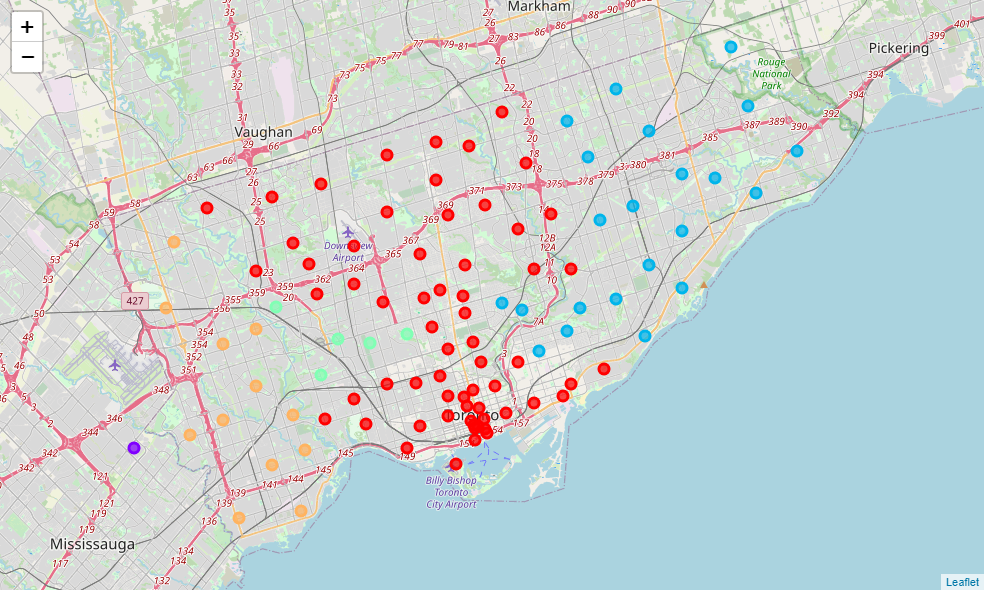